In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [2]:
if IN_COLAB:
    REF_PATH = "/content/drive/MyDrive/Project/"
else:
    REF_PATH = "../../data/"
REF_PATH += "Average pm25 per neighborhood BASELINE.csv"

In [3]:
TRIPS_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/NYC_Pilot2_PM_Part1.csv'
POLYGON_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'

In [4]:
import pandas as pd
import folium
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
import math
import matplotlib.pyplot as plt
from shapely import wkt

from s2 import s2

# Neighborhood Approximation

## <font color = 'blue'> Fixed Resolution and Variable Size </font>

### <font color = 'green'>- RMSE </font>

In [5]:
s2_resolution = 14

In [6]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [7]:
trips['s2'] = trips.apply(lambda x: s2.geo_to_s2(x.latitude, x.longitude, s2_resolution), axis = 1)

In [8]:
reference_value = pd.read_csv(REF_PATH)
reference_value['geometry'] = reference_value['geometry'].apply(wkt.loads)
reference_value = gpd.GeoDataFrame(reference_value, crs='epsg:4326')
print(reference_value['neighborhood'].nunique())
print(len(reference_value['neighborhood']))

48
48


In [9]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [10]:
def get_rmse_s2(baseline, encoded):
    error = []
    for sampling_frequency in np.arange(0.1,1.1,0.1):
        sampled_trips = encoded.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each s2 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each s2 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='s2', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
    return error

In [11]:
RMSE_S2 = get_rmse_s2(reference_value,trips)

In [12]:
RMSE_S2

[0.3013144202446185,
 0.28362503273950773,
 0.2733912891803425,
 0.25825770699417844,
 0.2728594865288679,
 0.270578404826593,
 0.26998681442043876,
 0.2694824971525924,
 0.26813175141824974,
 0.2658764131572397]

<Figure size 640x480 with 0 Axes>

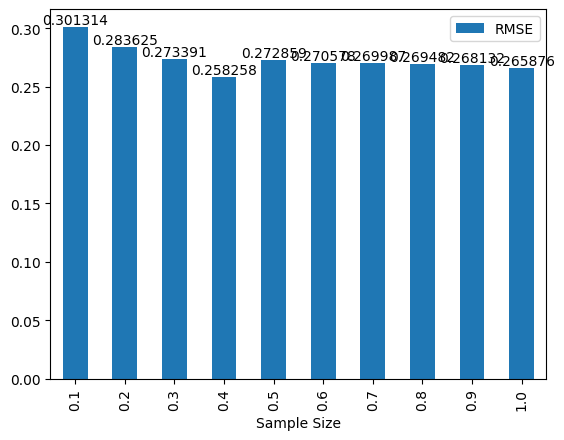

In [13]:
S2_Performance = pd.DataFrame({'Sample Size':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                               'RMSE': RMSE_S2})
plt.figure()
ax = S2_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

### <font color = 'green'>- MAPE </font>

In [14]:
s2_resolution = 14

In [15]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [16]:
trips['s2'] = trips.apply(lambda x: s2.geo_to_s2(x.latitude, x.longitude, s2_resolution), axis = 1)

In [17]:
def calculate_mape(predicted_values, actual_values):
    # Calculate absolute differences
    absolute_diff = np.abs(actual_values - predicted_values)
    
    # Calculate percentage error
    percentage_error = absolute_diff / actual_values
    
    # Handle cases where actual values are 0 to avoid division by zero
    percentage_error = np.nan_to_num(percentage_error, nan=0, posinf=0)
    
    # Calculate mean percentage error
    mean_percentage_error = np.mean(percentage_error)
    
    # Convert mean percentage error to percentage
    mape = mean_percentage_error * 100
    
    return mape

In [18]:
def get_mape_s2(baseline, encoded):
    error = []
    for sampling_frequency in np.arange(0.1,1.1,0.1):
        sampled_trips = encoded.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each s2 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each s2 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='s2', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        mape = calculate_mape(sampled_pm25, baseline_pm25)
        error.append(mape)
    return error

In [19]:
MAPE_S2 = get_mape_s2(reference_value,trips)

In [20]:
MAPE_S2

[4.4272126653445865,
 4.414346155227797,
 4.351526978922025,
 4.051854929431081,
 4.105963031736043,
 3.991769502398579,
 4.01514556487445,
 4.071480942765168,
 4.098024286853495,
 4.058857569624217]

<Figure size 640x480 with 0 Axes>

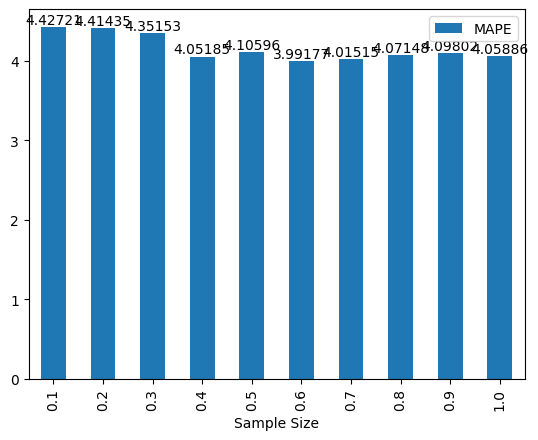

In [21]:
S2_Performance = pd.DataFrame({'Sample Size':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                               'MAPE': MAPE_S2})
plt.figure()
ax = S2_Performance.plot(kind='bar', x='Sample Size', y= 'MAPE')
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

## <font color = 'blue'> Fixed Size and Variable Resolution </font>

### <font color = 'green'>- RMSE </font>

In [22]:
s2_resolution_min = 0
s2_resolution_max = 30
sampling_frequency = 0.6

In [23]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [24]:
reference_value = pd.read_csv(REF_PATH)
reference_value['geometry'] = reference_value['geometry'].apply(wkt.loads)
reference_value = gpd.GeoDataFrame(reference_value, crs='epsg:4326')
print(reference_value['neighborhood'].nunique())
print(len(reference_value['neighborhood']))

48
48


In [25]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [26]:
def group_by_s2(df, s2_resolution):
    df['s2'] = df.apply(lambda x: s2.geo_to_s2(x.latitude, x.longitude, s2_resolution), axis=1)
    return df.groupby('s2')

In [27]:
def get_rmse_s2(baseline, encoded):
    error = []
    s2_resolution = s2_resolution_min
    while s2_resolution <= s2_resolution_max:
        sampled_trips = group_by_s2(encoded, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each s2 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each s2 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='s2', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse) #Append to Error list
        s2_resolution += 1
    return error

In [28]:
RMSE_S2 = get_rmse_s2(reference_value,trips)

In [29]:
RMSE_S2

[0.40892894232028737,
 0.4114980995018496,
 0.41794309437881644,
 0.4094797932308351,
 0.4096469682740297,
 0.4053876824371472,
 0.40428558213735033,
 0.3194559978698839,
 0.31719640675067456,
 0.32125629158882507,
 0.31299466847344937,
 0.2980527398680143,
 0.27291510065068436,
 0.2792542560825429,
 0.2649205991603031,
 0.43556291626889726,
 0.6200965219500675,
 0.779252463528785,
 0.9292458260898794,
 1.1224087385784474,
 1.3175006740837227,
 1.4835806349755027,
 1.5987699328490605,
 1.6585992310170194,
 1.6970574082241068,
 1.7033177121935088,
 1.7041857765976127,
 1.703371682964961,
 1.703789475311898,
 1.7075796657039182,
 1.7030639227084488]

<Figure size 640x480 with 0 Axes>

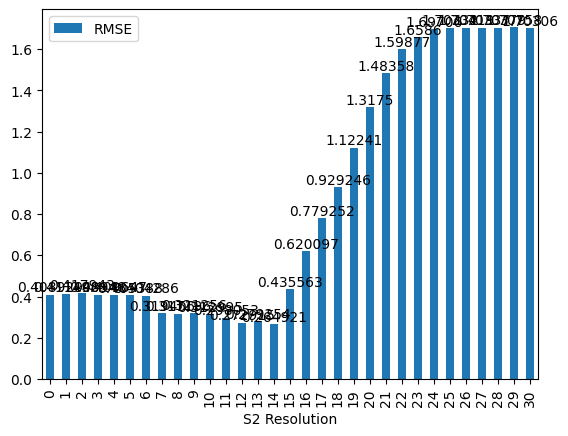

In [30]:
X_LABEL = 'S2 Resolution'
Y_LABEL = 'RMSE'
S2_Performance = pd.DataFrame({X_LABEL:list(range(s2_resolution_min, s2_resolution_max + 1)),
                               Y_LABEL: RMSE_S2})
plt.figure()
ax = S2_Performance.plot(kind='bar', x=X_LABEL, y=Y_LABEL)
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

### <font color = 'green'>- MAPE </font>

In [31]:
s2_resolution_min = 0
s2_resolution_max = 30
sampling_frequency = 0.6

In [32]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [33]:
reference_value = pd.read_csv(REF_PATH)
reference_value['geometry'] = reference_value['geometry'].apply(wkt.loads)
reference_value = gpd.GeoDataFrame(reference_value, crs='epsg:4326')
print(reference_value['neighborhood'].nunique())
print(len(reference_value['neighborhood']))

48
48


In [34]:
def calculate_mape(predicted_values, actual_values):
    # Calculate absolute differences
    absolute_diff = np.abs(actual_values - predicted_values)
    
    # Calculate percentage error
    percentage_error = absolute_diff / actual_values
    
    # Handle cases where actual values are 0 to avoid division by zero
    percentage_error = np.nan_to_num(percentage_error, nan=0, posinf=0)
    
    # Calculate mean percentage error
    mean_percentage_error = np.mean(percentage_error)
    
    # Convert mean percentage error to percentage
    mape = mean_percentage_error * 100
    
    return mape

In [35]:
def group_by_s2(df, s2_resolution):
    df['s2'] = df.apply(lambda x: s2.geo_to_s2(x.latitude, x.longitude, s2_resolution), axis=1)
    return df.groupby('s2')

In [36]:
def get_mape_s2(baseline, encoded):
    error = []
    s2_resolution = s2_resolution_min
    while s2_resolution <= s2_resolution_max:
        sampled_trips = group_by_s2(encoded, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each s2 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each s2 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='s2', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        mape = calculate_mape(sampled_pm25, baseline_pm25)
        error.append(mape) #Append to Error list
        s2_resolution += 1
    return error

In [37]:
MAPE_S2 = get_mape_s2(reference_value,trips)

In [38]:
MAPE_S2

[3.3947282848712854,
 3.476409979940493,
 3.446380656157862,
 3.4955954383935173,
 3.4723084982481867,
 3.3576127633469572,
 3.462733958434098,
 3.26978366219692,
 3.2897953152977695,
 3.2608904760090205,
 3.178171806481079,
 2.9898930557113514,
 2.8940780483289923,
 3.470782182089375,
 4.142721791900341,
 6.33625774569386,
 8.752499015921725,
 10.864236620267148,
 13.392614152754337,
 16.39891079667299,
 19.72867986371835,
 22.591403051444715,
 24.572729536233805,
 25.84240998037884,
 26.682627630199544,
 26.869124742891366,
 26.84132606783712,
 26.845847415662504,
 26.831515699244424,
 26.81704818327779,
 26.84261738853715]

<Figure size 640x480 with 0 Axes>

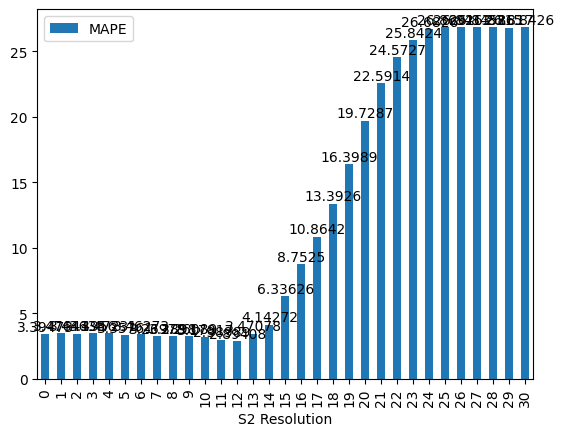

In [39]:
X_LABEL = 'S2 Resolution'
Y_LABEL = 'MAPE'
S2_Performance = pd.DataFrame({X_LABEL:list(range(s2_resolution_min, s2_resolution_max + 1)),
                               Y_LABEL: MAPE_S2})
plt.figure()
ax = S2_Performance.plot(kind='bar', x=X_LABEL, y=Y_LABEL)
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

# Stratified Sampling

## <font color = 'blue'> Fixed Resolution and Variable Size </font>

### <font color = 'green'>- RMSE </font>

In [40]:
s2_resolution = 14

In [41]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [42]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [43]:
trips['s2'] = trips.apply(lambda x: s2.geo_to_s2(x.latitude, x.longitude, s2_resolution), axis = 1)

In [44]:
population_pm25 = (trips
                .groupby('neighborhood')
                .pm25
                .agg(list)
                .to_frame("pm25_list")
                .reset_index())  # Make a list of pm25 values for each neighborhood

population_pm25['average_pm25_value'] = population_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
population_pm25.drop('pm25_list', axis = 1, inplace=True)

population_pm25.sort_values(by='neighborhood', inplace=True)
population_pm25.reset_index(drop=True, inplace=True)

In [45]:
def perform_test():
    error = []
    sample_size_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for sampling_frequency in sample_size_range:
        stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_pm25 = (stratified_sample
                    .groupby('neighborhood')
                    .pm25
                    .agg(list)
                    .to_frame("pm25_list")
                    .reset_index())  # Make a list of pm25 values for each neighborhood
        random_sample_pm25['average_pm25_value'] = random_sample_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
        random_sample_pm25.drop('pm25_list', axis = 1, inplace=True)
        for neighborhood in population_pm25["neighborhood"]:
            if neighborhood not in random_sample_pm25["neighborhood"].values:
                random_sample_pm25.loc[len(random_sample_pm25.index)] = [neighborhood, 0]
        random_sample_pm25.sort_values(by='neighborhood', inplace=True)
        random_sample_pm25.reset_index(drop=True, inplace=True)
        assert population_pm25['neighborhood'].equals(random_sample_pm25['neighborhood'])
        baseline_pm25 =    population_pm25["average_pm25_value"].values
        sampled_pm25  = random_sample_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
    S2_Performance = pd.DataFrame({'Sample Size': sample_size_range,
                                'RMSE': error})
    plt.figure()
    ax = S2_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()

<Figure size 640x480 with 0 Axes>

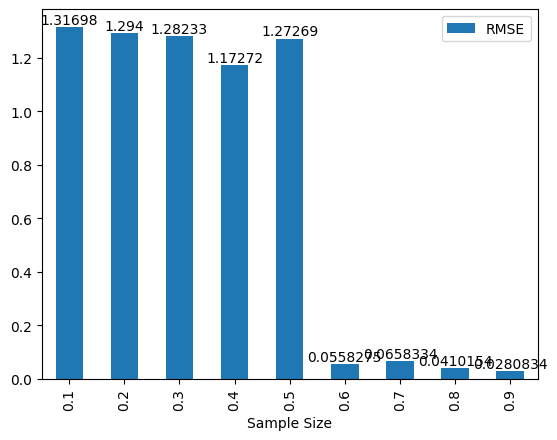

<Figure size 640x480 with 0 Axes>

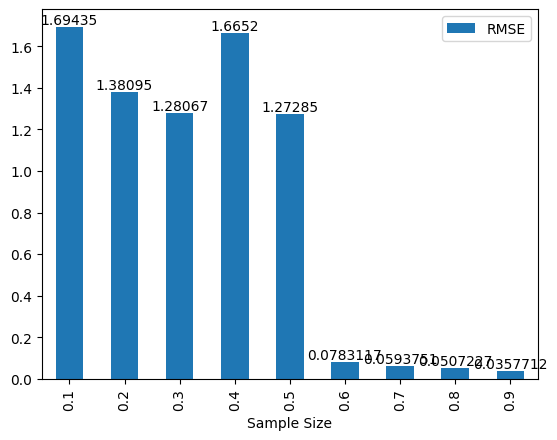

<Figure size 640x480 with 0 Axes>

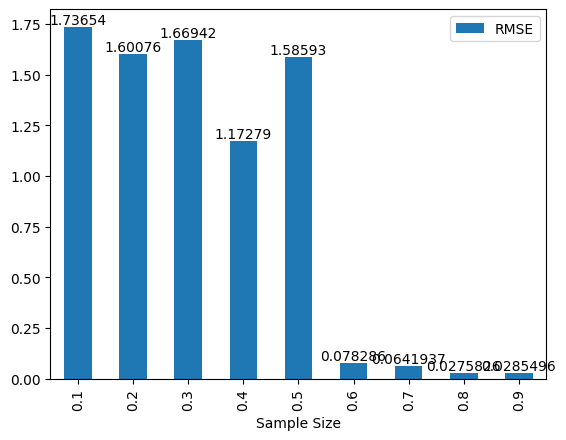

<Figure size 640x480 with 0 Axes>

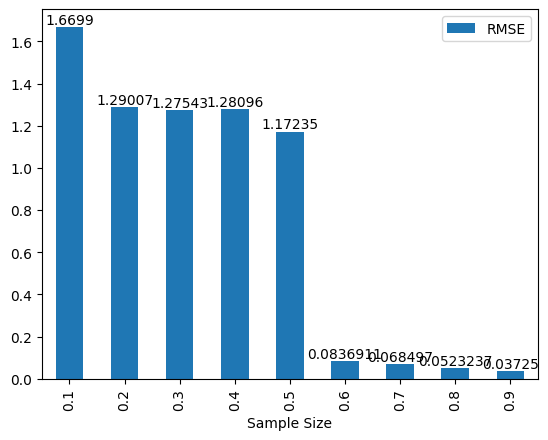

<Figure size 640x480 with 0 Axes>

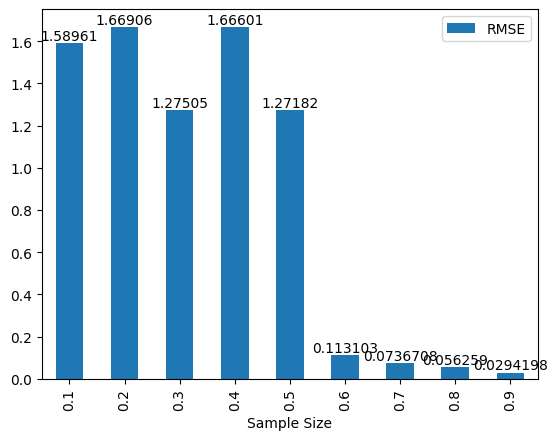

In [46]:
for _ in range(5):
    perform_test()

We see that when the S2 resolution is fixed to 14 and starting from sample size 60%, stratified sampling using S2 is reliable when it comes to reducing the dataset size while still retaining the same information on a neighborhood-level.

## <font color = 'blue'> Fixed Size and Variable Resolution </font>

### <font color = 'green'>- RMSE </font>

In [47]:
s2_resolution_min = 0
s2_resolution_max = 30
sampling_frequency = 0.6

In [48]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [49]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [50]:
population_pm25 = (trips
                .groupby('neighborhood')
                .pm25
                .agg(list)
                .to_frame("pm25_list")
                .reset_index())  # Make a list of pm25 values for each neighborhood

population_pm25['average_pm25_value'] = population_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
population_pm25.drop('pm25_list', axis = 1, inplace=True)

population_pm25.sort_values(by='neighborhood', inplace=True)
population_pm25.reset_index(drop=True, inplace=True)

In [51]:
def group_by_s2(df, s2_resolution):
    df['s2'] = df.apply(lambda x: s2.geo_to_s2(x.latitude, x.longitude, s2_resolution), axis=1)
    return df.groupby('s2')

In [52]:
def perform_test():
    error = []
    s2_resolution = s2_resolution_min
    while s2_resolution <= s2_resolution_max:
        stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_pm25 = (stratified_sample
                    .groupby('neighborhood')
                    .pm25
                    .agg(list)
                    .to_frame("pm25_list")
                    .reset_index())  # Make a list of pm25 values for each neighborhood
        random_sample_pm25['average_pm25_value'] = random_sample_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
        random_sample_pm25.drop('pm25_list', axis = 1, inplace=True)
        for neighborhood in population_pm25["neighborhood"]:
            if neighborhood not in random_sample_pm25["neighborhood"].values:
                random_sample_pm25.loc[len(random_sample_pm25.index)] = [neighborhood, 0]
        random_sample_pm25.sort_values(by='neighborhood', inplace=True)
        random_sample_pm25.reset_index(drop=True, inplace=True)
        assert population_pm25['neighborhood'].equals(random_sample_pm25['neighborhood'])
        baseline_pm25 =    population_pm25["average_pm25_value"].values
        sampled_pm25  = random_sample_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
        s2_resolution += 1
    S2_Performance = pd.DataFrame({'S2 Resolution':list(range(s2_resolution_min, s2_resolution_max + 1)),
                                'RMSE': error})
    plt.figure()
    ax = S2_Performance.plot(kind='bar', x='S2 Resolution', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()

<Figure size 640x480 with 0 Axes>

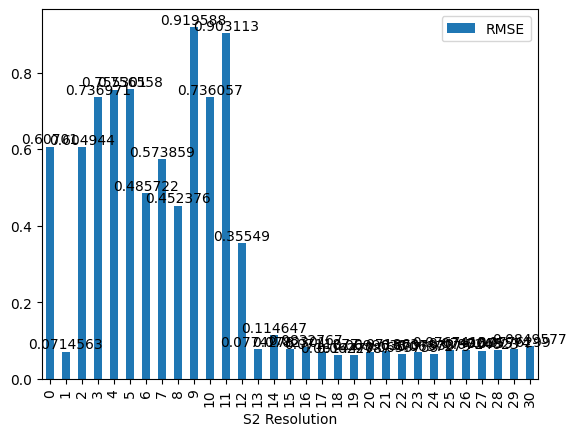

<Figure size 640x480 with 0 Axes>

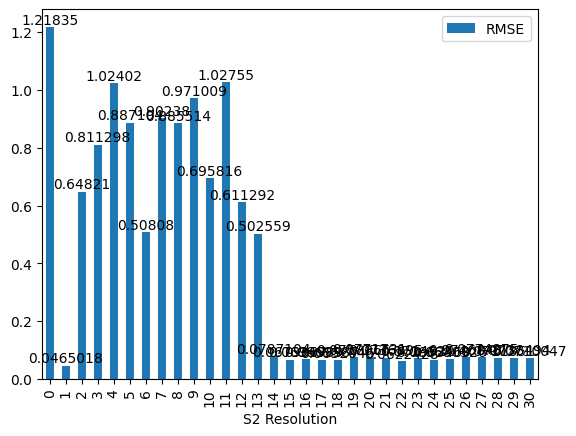

<Figure size 640x480 with 0 Axes>

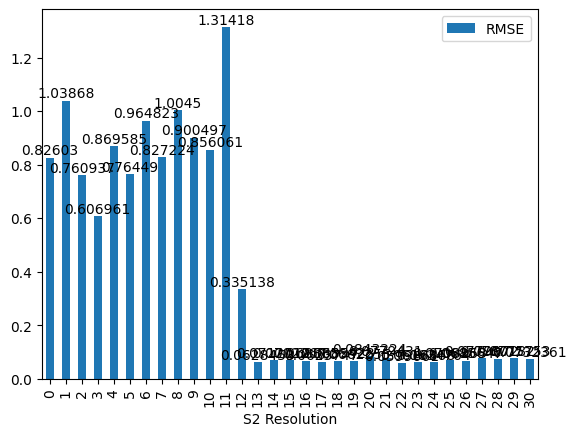

<Figure size 640x480 with 0 Axes>

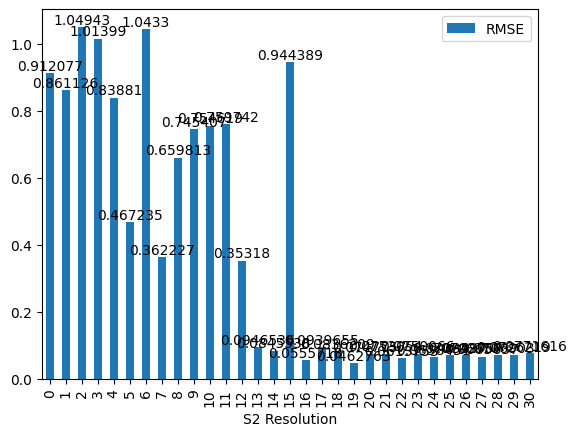

<Figure size 640x480 with 0 Axes>

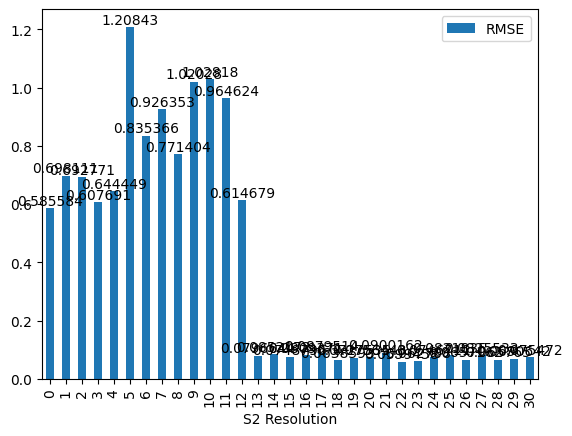

In [53]:
for _ in range(5):
    perform_test()

We see that with S2 resolutions >= 13, 60% is a good sample size to use for stratified sampling using S2 when it comes to reducing the dataset size while still retaining the same information on a neighborhood-level. (With some fluctuations in resolutions 13 and 14.)